1. 입력 초기 정보가 미래를 예측하는데 큰 영향을 미칠 때, 초기 정보를 저장해두는 것이 매우 중요하다. 정보를 저장해두지 않는다면, 해당 부분에 매우 큰 gradient를 주는 과정이 필요하다.
2. 적절하지 않은 의미를 담는 토큰들도 있을 수 있다. 웹사이트의 주제를 알기 위해 스크랩핑할 때, HTML의 문법적인 요소들이 담기는 경우가 그러하다. 이러한 경우는 적절하게 토큰들을 skipping 해줘야 한다.
3. 문법적인 오류가 있는 문장들도 있다. 책 챕터가 그 예시가 된다. 이러한 경우 internal state representation을 resetting 해주는 것이 좋다.

즉, long-term memory가 약한 것이 RNN의 특징인데, 이런 경우 위와 같은 문제 상황들을 해결할 수가 없다. 보완하기 위해 등장한 여러 모델들이 있는데, 그 중 GRU 먼저 배워보도록 하겠다.

# 9.1.1. Gated Hidden State
GRU와 RNN의 차이는, Hidden state를 받아들일지 말지 gating 과정을 거친다는 부분이다. 즉, 언제 update, reset이 되어야 할지 스스로 학습한다는 의미가 되겠다. 

예를 들어, 첫번째 토큰이 매우 큰 중요도를 가지면, 이후에 hidden state를 업데이터 하지 않을 수 있다. 일시적으로 나타나는 맥락없는 토큰들은 무시할 수 있고, 필요할 때 latent state를 reset할 수 있다.


## 9.1.1.1. Reset Gate and Update Gate

Reset gate는 이전의 state를 우리가 얼마나 기억할 것인지 정한다. update gate는 새로운 state가 얼마나 이전 state에 따를 것인지 정한다.

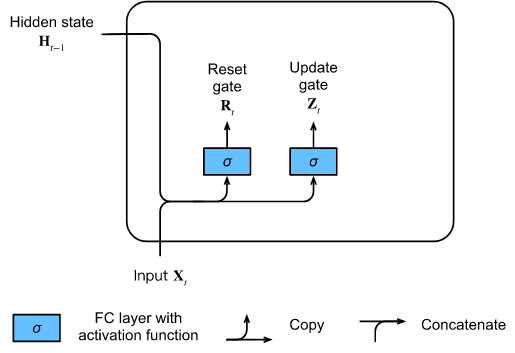

## 9.1.1.2. Candidate Hidden State

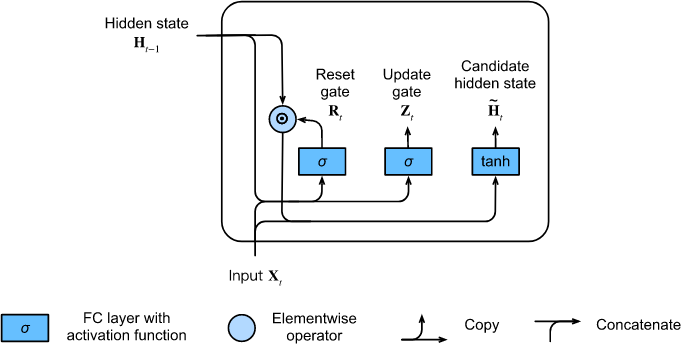

# 9.1.1.3. Hidden State
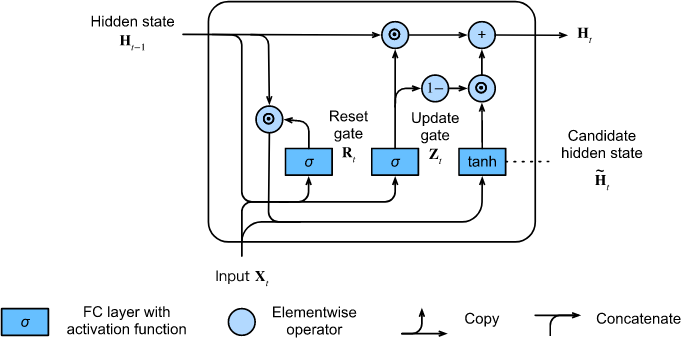

# 9.1.2. Implementation from Scratch

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 9.1.2.1. Initializing Model Parameters

### Reset Gate and Update Gate
\begin{split}\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}\end{split}

### Candidate Hidden State
\begin{split}\begin{aligned}
\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),
\end{aligned}\end{split}


### Hidden State

\begin{split}\begin{aligned}
\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.
\end{aligned}\end{split}

In [54]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param = param.to(torch.float32)
        param.requires_grad_(True)
    return params

## 9.1.2.2. Defining the Model

In [55]:
# init_rnn_state와 비슷하게, init_gru_state를 만들 것.
# 이를 통해, (batch_size, num_hiddens) 사이즈의 출력값을 얻을 수 있다.
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [56]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H = state
    outputs = []
    for X in inputs:
        X = X.to(torch.float32)
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

TypeError: unsupported operand type(s) for @: 'tuple' and 'Tensor'

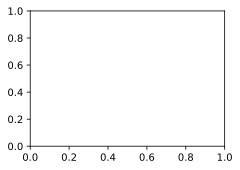

In [57]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 19514.1 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


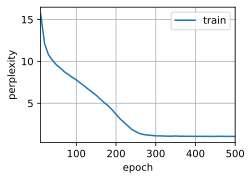

In [53]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)